In [1]:
from importlib import reload
import torch
from torch.nn import functional as F
from torch import nn, optim
from models.resnet import ResNet
from models.gnn.layers import GraphConvolution
from utils.sparse_matrix import get_matrix, get_adj
from utils.loader import GraphDataset
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import train
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from models.edge_agg_models import AggregationEdgeGNN
from models.gnn.layers import GraphConvolution
from models import resnet
from models import GAT
from sklearn.preprocessing import PolynomialFeatures, minmax_scale
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
reload(train)
reload(GAT)
reload(resnet)

<module 'models.resnet' from 'd:\\Master\\Luận văn\\Co2Al\\graph_based\\models\\resnet.py'>

In [3]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

In [4]:
def eval_normal(model, x, y, adj):
    with torch.no_grad():
        pred = torch.argmax(torch.softmax(model.cuda()(x.cuda().float(),
                                                       adj.cuda()),
                                          dim=1),
                            dim=1)
    print(classification_report(y, pred.cpu()))
    return pred


def eval_hybrid(model, x, y, adjs):
    with torch.no_grad():
        pred = torch.argmax(torch.softmax(model.cuda()(x.cuda().float(), *list(
            map(lambda s: s.float().cuda(), adjs))),
                                          dim=1),
                            dim=1)
    print(classification_report(y, pred.cpu()))
    print(accuracy_score(y, pred.cpu()))
    return pred

In [71]:
features = pd.read_csv("./dataset/node_03_11_2022.csv").to_numpy()
features_df = pd.read_csv("./dataset/node_03_11_2022.csv")
links = pd.read_csv("./dataset/link_03_11_2022.csv").to_numpy().astype(float)
links_df = pd.read_csv("./dataset/link_03_11_2022.csv")

In [76]:
import xgboost as xgb
from sklearn.metrics import precision_score,recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
def sort_by_another_list(df, column_name, sorter):
    sorterIndex = dict(zip(sorter, range(len(sorter))))
    df['Tm_Rank'] = df[column_name].map(sorterIndex)
    df.sort_values(['Tm_Rank'], ascending = [True], inplace = True)
    df.drop('Tm_Rank', 1, inplace = True)
    df.reset_index(inplace=True, drop=True)
    return df
def KQ(y_train, y_test,prediction_train,prediction_test):
    print('Accuracy_train:', accuracy_score(y_train, prediction_train))
    print('Accuracy_test:', accuracy_score(y_test, prediction_test))
    print('F1 score:', f1_score(y_test, prediction_test))
    print('Recall:', recall_score(y_test, prediction_test))
    print('Precision:', precision_score(y_test, prediction_test))
   # print('\n clasification report:\n', classification_report(y_test,prediction))
    print('\n confussion matrix:\n',confusion_matrix(y_test, prediction_test))
X = features_df.drop(columns=['phone_to', 'Spam'])
Y = features_df['Spam']

X_train, X_val, y_train, y_val = train_test_split(X,
                                                    Y,
                                                    test_size=0.3,
                                                    random_state=3)
XGB = xgb.XGBClassifier(objective='binary:logistic',
                        booster='gbtree',
                        colsample_bytree=1,
                        learning_rate=0.005,
                        max_depth=8,
                        min_child_weight=12,
                        scale_pos_weight=1,
                        n_estimators=3000,
                        random_state=1,
                        seed=1,
                        eta=0.3,
                        subsample=0.8,
                        tree_method='gpu_hist',
                        sampling_method='uniform')
# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_val, y_val)]
# fit the model
XGB.fit(X_train, y_train, eval_metric='auc', eval_set=evalset)
# save the model to disk
# joblib.dump(XGB, args.save_model)
# print('Save to ', args.save_model)

prediction_train = XGB.predict(X_train)
prediction_val =XGB.predict(X_val)
KQ(y_train, y_val, prediction_train, prediction_val)

[0]	validation_0-auc:0.97995	validation_1-auc:0.97593
[1]	validation_0-auc:0.98054	validation_1-auc:0.97678
[2]	validation_0-auc:0.98099	validation_1-auc:0.97716
[3]	validation_0-auc:0.98143	validation_1-auc:0.97773
[4]	validation_0-auc:0.98159	validation_1-auc:0.97780


c:\Users\GroooDev\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[5]	validation_0-auc:0.98157	validation_1-auc:0.97774
[6]	validation_0-auc:0.98163	validation_1-auc:0.97771
[7]	validation_0-auc:0.98206	validation_1-auc:0.97829
[8]	validation_0-auc:0.98212	validation_1-auc:0.97837
[9]	validation_0-auc:0.98212	validation_1-auc:0.97842
[10]	validation_0-auc:0.98213	validation_1-auc:0.97847
[11]	validation_0-auc:0.98223	validation_1-auc:0.97861
[12]	validation_0-auc:0.98223	validation_1-auc:0.97858
[13]	validation_0-auc:0.98228	validation_1-auc:0.97864
[14]	validation_0-auc:0.98233	validation_1-auc:0.97869
[15]	validation_0-auc:0.98234	validation_1-auc:0.97869
[16]	validation_0-auc:0.98234	validation_1-auc:0.97873
[17]	validation_0-auc:0.98237	validation_1-auc:0.97880
[18]	validation_0-auc:0.98241	validation_1-auc:0.97892
[19]	validation_0-auc:0.98243	validation_1-auc:0.97890
[20]	validation_0-auc:0.98250	validation_1-auc:0.97892
[21]	validation_0-auc:0.98250	validation_1-auc:0.97893
[22]	validation_0-auc:0.98250	validation_1-auc:0.97893
[23]	validation

In [6]:
# features_df = pd.read_csv("./dataset/node_03_11_2022.csv", converters={ 'phone_to': lambda x: str(x)},
#     low_memory=False)

In [7]:
f_train, f_test, y_train, y_test = train_test_split(features,
                                                    features[:, -1],
                                                    test_size=0.3,
                                                    random_state=42)


In [8]:
link_train = links_df[links_df['phone_to'].isin(
    f_train[:, 0])][links_df['phone_in'].isin(f_train[:, 0])]

link_test = links_df[links_df['phone_to'].isin(
    f_test[:, 0])][links_df['phone_in'].isin(f_test[:, 0])]


<ipython-input-8-6b0e821f1c13>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  link_train = links_df[links_df['phone_to'].isin(
<ipython-input-8-6b0e821f1c13>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  link_test = links_df[links_df['phone_to'].isin(


In [9]:
def get_dataset(features, links, num_nodes):
    labels = torch.from_numpy(features[:, -1]).long()
    adjs = []
    for i in range(2, links.shape[1]):
        adj = get_adj(features, links[:, [0, 1, i]]).float()
        adjs.append(get_matrix(adj, num_nodes))
    adj = get_adj(features, links)
    nrm_adj = get_matrix(adj, num_nodes).float()

    features = torch.from_numpy(features[:, 1:-1]).float()
    # features_poly = poly.fit_transform(features)
    features_poly = minmax_scale(features)
    features_poly = torch.from_numpy(features_poly).float()
    dataset = GraphDataset(features_poly, labels)
    return dataset, nrm_adj, adjs

In [10]:
dataset_train, nrm_adj_train, adjs_train = get_dataset(
    f_train,
    link_train.to_numpy().astype(float), f_train.shape[0])


In [11]:
dataset_test, nrm_adj_test, adjs_test = get_dataset(
    f_test,
    link_test.to_numpy().astype(float), f_test.shape[0])


In [12]:
def get_optimizer(t: str):
    if t == "adam":
        return optim.Adam
    elif t == "sgd":
        return optim.SGD
    elif t == 'adagrad':
        return optim.Adarad
    elif t == 'adamw':
        return optim.AdamW


def get_criterion(t: str):
    if t == "nll_loss":
        return nn.CrossEntropyLoss
    elif t == "kl":
        return nn.KLDivLoss
    elif t == 'multilabel':
        return nn.MultiLabelSoftMarginLoss
    else:
        return nn.CrossEntropyLoss


def train_no_hybrid(model,
                    dataset,
                    adj,
                    optimizer: str,
                    criterion: str,
                    device,
                    lr: float = 1e-3,
                    epoches: int = 20,
                    lr_scheduler: bool = True,
                    return_loss: bool = True):
    """Function for training model

    Args:
        model (nn.Module): A model written in PyTorch.
                            An instance of class inherited nn.Module
        dataset (torch.data.Dataset): PyTorch Dataset. See documentation.
        adj (torch.sparse): PyTorch sparse matrix. Should be coo_tensor.
        optimizer (str): Name of optimizer.
                        Available: adam, sgd, adagrad
        criterion (str): Loss function. Currently only `nll_loss` is accepted
        device (str, torch.device): Device for training. Cuda/cpu
        lr (float, optional): Learning rate. Defaults to 1e-3.
        epoches (int, optional): Number of epoches. Defaults to 20.
        lr_scheduler (bool, optional): True if using scheduler.
                                Defaults to True.
        return_loss(bool, optional): True to trace loss in training progress.

    Returns:
        model: Trained model
    """

    optimizer = get_optimizer(optimizer)(model.parameters(), lr=lr)
    criterion = get_criterion(criterion)()
    if lr_scheduler:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer)
    if return_loss:
        tracked_loss = []
    for _ in tqdm(range(epoches)):
        x, y = dataset.data, dataset.targets
        x = x.to(device)
        y = y.to(device).flatten()
        adj = adj.to(device)
        pred = model(x, adj)
        optimizer.zero_grad()
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        if return_loss:
            with torch.no_grad():
                tracked_loss.append(loss.item())
        if lr_scheduler:
            scheduler.step(loss)
    if return_loss:
        return model, tracked_loss
    else:
        return model


def train_hybrid(model,
                 dataset,
                 adjs,
                 optimizer: str,
                 criterion: str,
                 device,
                 lr: float = 1e-3,
                 epoches: int = 20,
                 lr_scheduler: bool = True,
                 return_loss: bool = True):
    """Function for training model

    Args:
        model (nn.Module): A model written in PyTorch.
                            An instance of class inherited nn.Module
        dataset (torch.data.Dataset): PyTorch Dataset. See documentation.
        adjs (torch.sparse): List of PyTorch sparse matrix.
                            Each layer contains weights of rel between nodes.
        optimizer (str): Name of optimizer.
                        Available: adam, sgd, adagrad
        criterion (str): Loss function.
                        Available: nll_loss, KLDivLoss
        device (str, torch.device): Device for training. Cuda/cpu
        lr (float, optional): Learning rate. Defaults to 1e-3.
        epoches (int, optional): Number of epoches. Defaults to 20.
        lr_scheduler (bool, optional): True if using scheduler.
                                Defaults to True.
        return_loss(bool, optional): True to trace loss in training progress.

    Returns:
        model: Trained model
    """
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = get_criterion(criterion)()
    if lr_scheduler:
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 100, 0.5)

    if return_loss:
        tracked_loss = []

    adjs = list(map(lambda a: a.to(device).float(), adjs))

    for _ in tqdm(range(1, epoches + 1)):
        x, y = dataset.data, dataset.targets
        x = x.to(device).float()
        y = y.to(device)
        pred = model(x, *adjs).float()

        if isinstance(criterion, torch.nn.modules.loss.CrossEntropyLoss):
            y = y.flatten().long()
        elif isinstance(criterion, torch.nn.modules.loss.KLDivLoss):
            y = F.one_hot(y.flatten()).float()
            pred = F.log_softmax(pred, dim=1)
        elif isinstance(criterion,
                        torch.nn.modules.loss.MultiLabelSoftMarginLoss):
            y = F.one_hot(y.flatten()).float()
            pred = F.log_softmax(pred, dim=1)
        optimizer.zero_grad()
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        if lr_scheduler:
            lr_scheduler.step()
        if return_loss:
            with torch.no_grad():
                tracked_loss.append(loss.item())
    if return_loss:
        return model, tracked_loss
    else:
        return model

In [14]:
len(links_df.columns)

12

In [15]:
net = resnet.ResNet(GraphConvolution,
                    in_features=10,
                    cfg=[12, 12, 24, 24, 48],
                    n_residual_units=[2, 2, 3, 3, 2],
                    hidden_layers_fc=[24, 12],
                    num_classes=2).cuda()


In [16]:
# for a in adjs:
#     net, loss = train_no_hybrid(net, dataset, a.float(), 'adam', 'multilabel', 'cuda', 5e-4, 200)

In [17]:
# plt.plot(loss)
# print(loss[-1])

In [18]:
# eval_normal(net, dataset.data, dataset.targets, nrm_adj)

In [38]:
nets = [
    resnet.ResNet(GraphConvolution,
                  in_features=10,
                  cfg=[12, 12, 24],
                  n_residual_units=[2, 2, 3],
                  hidden_layers_fc=None,
                  num_classes=None) for _ in range(10)
]


In [39]:
class HybridGNN(nn.Module):
    def __init__(self, out_features, device, *gnns):
        super(HybridGNN, self).__init__()
        self.device = device
        self.leaky_relu = nn.LeakyReLU()
        for i, gnn in enumerate(gnns):
            self.__setattr__(f"gnn_{i}", gnn)
        self.fc = nn.Sequential(nn.LazyLinear(72), nn.LeakyReLU(),
                                nn.Linear(72, 36), nn.ReLU(),
                                nn.Linear(36, out_features))

    def forward(self, x, *adjacencies):
        x = x.to(self.device)
        out = torch.tensor([]).to(self.device)
        for i, adj in enumerate(adjacencies):
            adj = adj.to(self.device)
            layer = self.__getattr__(f"gnn_{i}")
            out = torch.cat([out, layer.forward(x, adj)], dim=1)
        out = self.leaky_relu(out)
        out = self.fc(out)
        out = self.leaky_relu(out)
        return out

In [40]:
model = HybridGNN(2, 'cuda', *nets).cuda()

In [41]:
cummulative = []

In [42]:
# dataset, _, adjs = get_dataset(features, links, features.shape[0])

In [78]:
model, loss = train_hybrid(model, dataset_train, adjs_train, 'adamw',
                           'multilabel', 'cuda', 1e-4, 500)
cummulative.extend(loss)

100%|██████████| 500/500 [04:07<00:00,  2.02it/s]


In [68]:
pred = eval_hybrid(model, dataset_train.data, dataset_train.targets,
                   adjs_train)


              precision    recall  f1-score   support

           0       0.94      0.92      0.93     27444
           1       0.87      0.90      0.88     16412

    accuracy                           0.91     43856
   macro avg       0.90      0.91      0.90     43856
weighted avg       0.91      0.91      0.91     43856

0.9087012039401678


In [81]:
pred = eval_hybrid(model, dataset_test.data, dataset_test.targets,
                   adjs_test)


              precision    recall  f1-score   support

           0       0.87      0.94      0.91     11598
           1       0.89      0.78      0.83      7198

    accuracy                           0.88     18796
   macro avg       0.88      0.86      0.87     18796
weighted avg       0.88      0.88      0.88     18796

0.8788572036603532


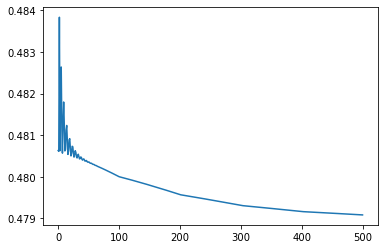

In [77]:
plt.plot(loss)

In [79]:
torch.save(model.state_dict(), "mode_grahpbased.pt")